# 🌲 Week 09 — 랜덤포레스트 실습

> **단일 의사결정트리 vs. 랜덤포레스트**, 코드로 직접 확인한다.

| 차시 | 주제 | 키워드 |
|:----:|------|--------|
| 1 | 앙상블 아이디어 & 배깅 원리 | 부트스트랩, 분산 감소, 다수결 |
| 2 | 랜덤포레스트 구조 & 하이퍼파라미터 | `n_estimators`, `max_features`, OOB |
| **3** | **실습 — 이 노트북** | 성능 비교, 피처 중요도, 시각화 |

---

## 0. 환경 설정

In [1]:
"""Colab 환경 설정 및 라이브러리 임포트."""

from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# ── Colab / Matplotlib 한글 깨짐 방지 ──
plt.rcParams.update({
    "axes.unicode_minus": False,
    "figure.dpi": 120,
    "font.size": 11,
})

# ── 상수 ──
RANDOM_STATE: int = 42          # 재현성 시드
CV_FOLDS: int = 5               # 교차검증 폴드 수
TOP_K_FEATURES: int = 10        # 시각화할 상위 피처 수
SEPARATOR_W: int = 62           # 출력 구분선 폭

print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


## 1. 데이터 로드 — `breast_cancer`

> 7주차와 **동일한 데이터**를 사용합니다.

In [2]:
"""breast_cancer 데이터를 로드하고 기본 정보를 확인한다."""

data = load_breast_cancer()
X: np.ndarray = data.data            # (569, 30)
y: np.ndarray = data.target           # 0=malignant, 1=benign
feature_names: np.ndarray = data.feature_names

n_samples, n_features = X.shape
class_counts = dict(zip(data.target_names, np.bincount(y)))

print(f"샘플 수  : {n_samples}")
print(f"피처 수  : {n_features}")
print(f"클래스   : {class_counts}")

샘플 수  : 569
피처 수  : 30
클래스   : {np.str_('malignant'): np.int64(212), np.str_('benign'): np.int64(357)}


## 2. 모델 정의 — 단일 트리 vs. 랜덤포레스트

| 모델 | 핵심 설정 | 비고 |
|------|-----------|------|
| **단일 트리** | `max_depth=3` | 7주차 교차검증 최적 깊이 |
| **랜덤포레스트** | `n_estimators=100`, `max_features='sqrt'` | 기본값으로 시작 |

In [3]:
"""두 모델을 정의한다. 아직 학습(fit)하지 않는다."""

single_tree = DecisionTreeClassifier(
    max_depth=3,
    random_state=RANDOM_STATE,
)

random_forest = RandomForestClassifier(
    n_estimators=100,          # 트리 100그루 — "많을수록 안전"
    max_features="sqrt",       # 분할마다 √30 ≈ 5개 피처만 후보
    random_state=RANDOM_STATE,
)

print("모델 정의 완료")
print(f"  · 단일 트리      : max_depth={single_tree.max_depth}")
print(f"  · 랜덤포레스트   : n_estimators={random_forest.n_estimators}, "
      f"max_features='{random_forest.max_features}'")

모델 정의 완료
  · 단일 트리      : max_depth=3
  · 랜덤포레스트   : n_estimators=100, max_features='sqrt'


## 3. 교차검증 성능 비교 ⭐

> **핵심 질문**: `RandomForestClassifier`의 교차검증 성능이
> 7주차 단일 트리(`max_depth=3`)보다 **정말 높은가?**

확인 포인트 3가지:
1. **평균 정확도** — RF가 더 높은가?
2. **표준편차** — RF가 더 안정적인가? (= 분산 감소 효과)
3. **각 Fold** — 대부분의 Fold에서 RF가 우세한가?

In [4]:
"""5-Fold 교차검증으로 두 모델의 정확도를 비교한다."""


def compare_cv_scores(
    scores_a: np.ndarray,
    scores_b: np.ndarray,
    name_a: str = "모델 A",
    name_b: str = "모델 B",
) -> float:
    """두 모델의 교차검증 점수를 포맷팅하여 출력한다.

    Args:
        scores_a: 모델 A의 Fold별 점수 배열.
        scores_b: 모델 B의 Fold별 점수 배열.
        name_a: 모델 A의 표시 이름.
        name_b: 모델 B의 표시 이름.

    Returns:
        두 모델의 평균 점수 차이 (B - A).
    """
    w = SEPARATOR_W
    col_a, col_b = 12, 14
    print("=" * w)
    print(f"{'교차검증 비교':^{w}}")
    print("=" * w)
    print(f"{'':>18} {name_a:>{col_a}} {name_b:>{col_b}}")
    print("-" * w)

    for fold, (sa, sb) in enumerate(zip(scores_a, scores_b), 1):
        win = " ✓" if sb > sa else ("" if sb == sa else " ✗")
        print(f"  Fold {fold}:         {sa:>{col_a}.4f} {sb:>{col_b}.4f}{win}")

    print("-" * w)
    print(f"  평균:           {scores_a.mean():>{col_a}.4f} "
          f"{scores_b.mean():>{col_b}.4f}")
    print(f"  표준편차:       {scores_a.std():>{col_a}.4f} "
          f"{scores_b.std():>{col_b}.4f}")
    print("=" * w)

    diff = scores_b.mean() - scores_a.mean()
    direction = "높음" if diff > 0 else "낮음"
    print(f"\n→ {name_b}가 {name_a}보다 "
          f"평균 {abs(diff):.4f} ({abs(diff) * 100:.2f}%p) {direction}")

    # 오류율 관점 해석
    err_a = (1 - scores_a.mean()) * 100
    err_b = (1 - scores_b.mean()) * 100
    print(f"→ 오류율: {name_a} {err_a:.1f}% → {name_b} {err_b:.1f}%")
    return diff


# ── 교차검증 실행 ──
scores_tree = cross_val_score(
    single_tree, X, y, cv=CV_FOLDS, scoring="accuracy",
)
scores_rf = cross_val_score(
    random_forest, X, y, cv=CV_FOLDS, scoring="accuracy",
)

_ = compare_cv_scores(scores_tree, scores_rf, "단일 트리", "랜덤포레스트")

                           교차검증 비교                            
                          단일 트리         랜덤포레스트
--------------------------------------------------------------
  Fold 1:               0.9123         0.9211 ✓
  Fold 2:               0.8947         0.9386 ✓
  Fold 3:               0.9386         0.9825 ✓
  Fold 4:               0.9561         0.9649 ✓
  Fold 5:               0.8938         0.9735 ✓
--------------------------------------------------------------
  평균:                 0.9191         0.9561
  표준편차:             0.0246         0.0228

→ 랜덤포레스트가 단일 트리보다 평균 0.0370 (3.70%p) 높음
→ 오류율: 단일 트리 8.1% → 랜덤포레스트 4.4%


## 4. OOB(Out-of-Bag) 점수 — "공짜 교차검증"

> 부트스트랩에서 **빠진 ~37% 데이터**로 평가하므로,
> 별도의 데이터 분할 없이 모델 성능을 추정할 수 있다.

```
oob_score=True  →  model.oob_score_
```

In [5]:
"""OOB 점수를 교차검증 결과와 비교한다."""

rf_oob = RandomForestClassifier(
    n_estimators=100,
    max_features="sqrt",
    oob_score=True,
    random_state=RANDOM_STATE,
)
rf_oob.fit(X, y)

print(f"OOB 점수       : {rf_oob.oob_score_:.4f}")
print(f"교차검증 평균  : {scores_rf.mean():.4f}")
print(f"차이           : {abs(rf_oob.oob_score_ - scores_rf.mean()):.4f}")
print()
print("→ OOB 점수 ≈ 교차검증 평균  ⟹  부트스트랩의 부산물로 얻는 공짜 평가!")

OOB 점수       : 0.9613
교차검증 평균  : 0.9561
차이           : 0.0052

→ OOB 점수 ≈ 교차검증 평균  ⟹  부트스트랩의 부산물로 얻는 공짜 평가!


## 5. 피처 중요도 비교 ⭐ — 테이블

> **핵심 관찰**:
> - 단일 트리 → 소수 피처에 **집중** (나머지 0)
> - 랜덤포레스트 → 여러 피처에 **분산** (거의 모두 > 0)
>
> 이유: 피처 랜덤 선택 → 강한 피처가 후보에서 빠지는 트리 존재 → 다른 피처도 기여

In [6]:
"""두 모델의 피처 중요도를 테이블로 비교한다."""


def print_importance_table(
    imp_a: np.ndarray,
    imp_b: np.ndarray,
    names: np.ndarray,
    name_a: str = "모델 A",
    name_b: str = "모델 B",
    top_k: int = TOP_K_FEATURES,
) -> np.ndarray:
    """두 모델의 피처 중요도를 상위 k개까지 비교 출력한다.

    Args:
        imp_a: 모델 A의 피처 중요도 배열.
        imp_b: 모델 B의 피처 중요도 배열.
        names: 피처 이름 배열.
        name_a: 모델 A의 표시 이름.
        name_b: 모델 B의 표시 이름.
        top_k: 출력할 상위 피처 수.

    Returns:
        모델 B 기준 내림차순 정렬된 피처 인덱스 배열.
    """
    sorted_idx = np.argsort(imp_b)[::-1]
    w = 72

    print("=" * w)
    print(f"{'피처 중요도 비교':^{w}}")
    print("=" * w)
    print(f"{'순위':>4}  {'피처':>25}  {name_a:>12}  {name_b:>14}")
    print("-" * w)

    for rank, idx in enumerate(sorted_idx[:top_k], 1):
        delta = imp_b[idx] - imp_a[idx]
        arrow = "↑" if delta > 0.01 else ("↓" if delta < -0.01 else "≈")
        print(f"{rank:>4}  {names[idx]:>25}  "
              f"{imp_a[idx]:>12.4f}  {imp_b[idx]:>14.4f}  {arrow}")

    print("-" * w)

    used_a = (imp_a > 0).sum()
    used_b = (imp_b > 0).sum()
    print(f"\n사용된 피처 수 (중요도 > 0):")
    print(f"  · {name_a:<14}: {used_a:>2}개 / {len(imp_a)}개")
    print(f"  · {name_b:<14}: {used_b:>2}개 / {len(imp_b)}개")

    return sorted_idx


# ── 전체 데이터로 학습 ──
single_tree.fit(X, y)
random_forest.fit(X, y)

imp_tree = single_tree.feature_importances_
imp_rf = random_forest.feature_importances_

rf_sorted_idx = print_importance_table(
    imp_tree, imp_rf, feature_names,
    name_a="단일 트리", name_b="랜덤포레스트",
)

                               피처 중요도 비교                                
  순위                         피처         단일 트리          랜덤포레스트
------------------------------------------------------------------------
   1                 worst area        0.0000          0.1394  ↑
   2       worst concave points        0.1165          0.1322  ↑
   3        mean concave points        0.0346          0.1070  ↑
   4               worst radius        0.7569          0.0828  ↓
   5            worst perimeter        0.0000          0.0808  ↑
   6             mean perimeter        0.0000          0.0680  ↑
   7             mean concavity        0.0000          0.0669  ↑
   8                  mean area        0.0000          0.0605  ↑
   9            worst concavity        0.0000          0.0373  ↑
  10                mean radius        0.0000          0.0348  ↑
------------------------------------------------------------------------

사용된 피처 수 (중요도 > 0):
  · 단일 트리         :  7개 / 30개
  · 랜덤포레스트        

## 6. 피처 중요도 비교 ⭐ — 시각화

> 왼쪽(단일 트리)은 **한 피처에 올인**, 오른쪽(랜덤포레스트)은 **분산 투자**.

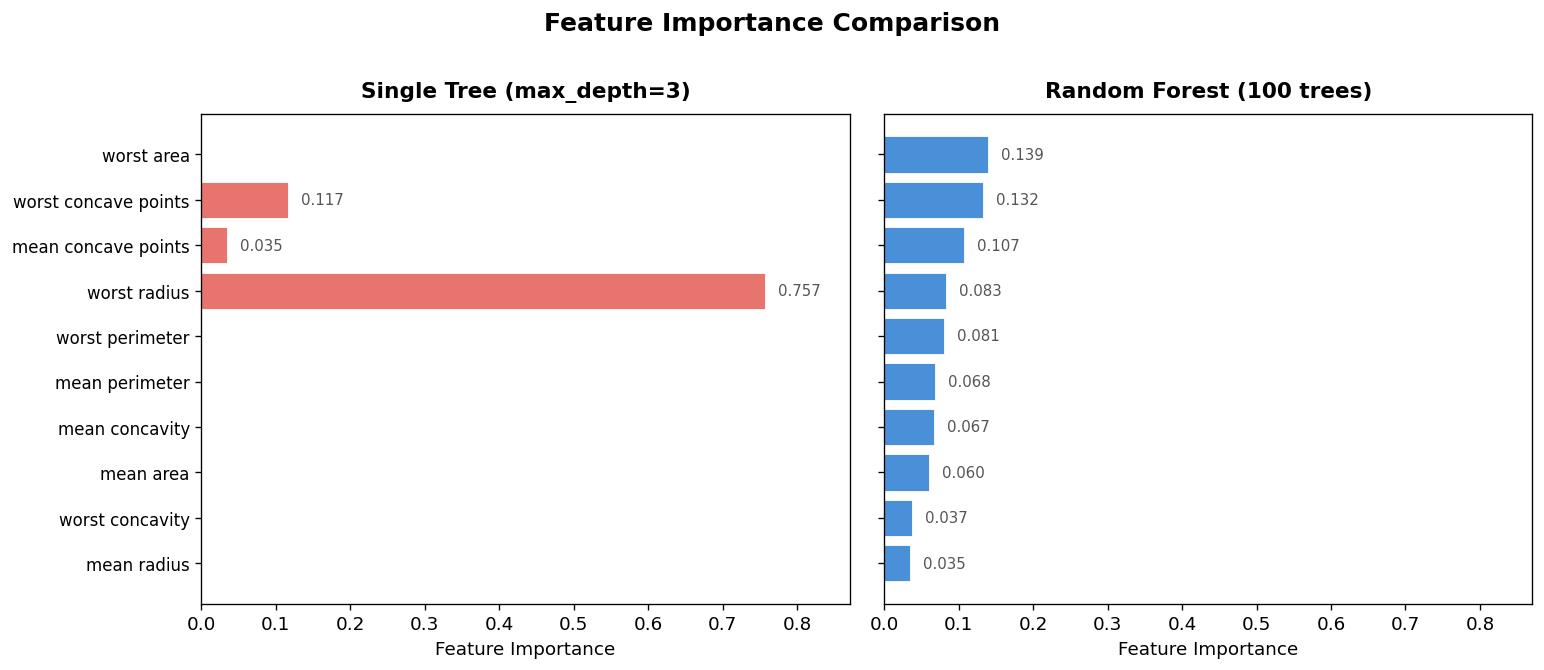

In [7]:
"""상위 피처의 중요도를 수평 막대 그래프로 비교한다."""


def plot_importance_comparison(
    imp_a: np.ndarray,
    imp_b: np.ndarray,
    names: np.ndarray,
    sorted_idx: np.ndarray,
    title_a: str = "Single Tree",
    title_b: str = "Random Forest",
    top_k: int = TOP_K_FEATURES,
) -> None:
    """두 모델의 피처 중요도를 나란히 시각화한다.

    Args:
        imp_a: 모델 A의 피처 중요도.
        imp_b: 모델 B의 피처 중요도.
        names: 피처 이름 배열.
        sorted_idx: 정렬 기준 인덱스 (모델 B 기준 내림차순).
        title_a: 왼쪽 서브플롯 제목.
        title_b: 오른쪽 서브플롯 제목.
        top_k: 표시할 상위 피처 수.
    """
    idx = sorted_idx[:top_k]
    top_names = names[idx]
    x_max = max(imp_a.max(), imp_b.max()) * 1.15

    fig, axes = plt.subplots(1, 2, figsize=(13, 5.5), sharey=True)

    # ── 왼쪽: 모델 A ──
    bars_a = axes[0].barh(
        range(top_k), imp_a[idx],
        color="#E8756D", edgecolor="white", linewidth=0.5,
    )
    axes[0].set_title(title_a, fontsize=13, fontweight="bold", pad=10)
    axes[0].set_xlabel("Feature Importance")
    axes[0].set_xlim(0, x_max)
    axes[0].set_yticks(range(top_k))
    axes[0].set_yticklabels(top_names, fontsize=10)
    axes[0].invert_yaxis()

    for bar, val in zip(bars_a, imp_a[idx]):
        if val > 0.005:
            axes[0].text(
                val + x_max * 0.02, bar.get_y() + bar.get_height() / 2,
                f"{val:.3f}", va="center", fontsize=9, color="#555",
            )

    # ── 오른쪽: 모델 B ──
    bars_b = axes[1].barh(
        range(top_k), imp_b[idx],
        color="#4A90D9", edgecolor="white", linewidth=0.5,
    )
    axes[1].set_title(title_b, fontsize=13, fontweight="bold", pad=10)
    axes[1].set_xlabel("Feature Importance")
    axes[1].set_xlim(0, x_max)

    for bar, val in zip(bars_b, imp_b[idx]):
        if val > 0.005:
            axes[1].text(
                val + x_max * 0.02, bar.get_y() + bar.get_height() / 2,
                f"{val:.3f}", va="center", fontsize=9, color="#555",
            )

    fig.suptitle(
        "Feature Importance Comparison",
        fontsize=15, fontweight="bold", y=1.01,
    )
    plt.tight_layout()
    plt.show()


plot_importance_comparison(
    imp_tree, imp_rf, feature_names, rf_sorted_idx,
    title_a="Single Tree (max_depth=3)",
    title_b="Random Forest (100 trees)",
)

## 7. 실습 결과 종합

| 평가 기준 | 단일 트리 (`max_depth=3`) | 랜덤포레스트 (100개) | 해석 |
|-----------|:--:|:--:|------|
| 교차검증 평균 정확도 | ~0.92 | ~0.96 | RF가 **~4%p 높음** |
| 교차검증 표준편차 | 큼 (불안정) | 작음 (안정적) | **분산 감소** 효과 |
| 오류율 | ~8% | ~4% | 오류 **절반 감소** |
| 피처 중요도 분포 | 소수 집중 | 다수 분산 | 피처 랜덤 선택 효과 |
| 중요도 > 0 피처 수 | ~7개 | 30개 전부 | 더 많은 피처가 기여 |
| 해석 가능성 | ✅ `plot_tree` 가능 | ❌ 트리 100개 읽기 불가 | **트레이드오프** |

---

## 📝 과제 1: `n_estimators` 변화 실험

> **질문**: 트리 수를 키울수록 정확도가 계속 올라가는가, 아니면 **포화**되는가?
>
> 차시 2에서 "n_estimators를 키워도 과적합이 안 된다"고 했다. 실험 결과가 이를 확인해주는가?

In [8]:
"""n_estimators를 변화시키며 교차검증 정확도 추이를 확인한다."""

N_ESTIMATOR_VALUES: Sequence[int] = [10, 50, 100, 200, 500]

means: list[float] = []
stds: list[float] = []

print("=" * SEPARATOR_W)
print(f"{'n_estimators 변화 실험':^{SEPARATOR_W}}")
print("=" * SEPARATOR_W)

for n in N_ESTIMATOR_VALUES:
    rf = RandomForestClassifier(
        n_estimators=n,
        max_features="sqrt",
        random_state=RANDOM_STATE,
    )
    scores = cross_val_score(rf, X, y, cv=CV_FOLDS, scoring="accuracy")
    means.append(scores.mean())
    stds.append(scores.std())
    print(f"  n_estimators = {n:>4}  →  "
          f"정확도 = {scores.mean():.4f}  (±{scores.std():.4f})")

print("=" * SEPARATOR_W)

                      n_estimators 변화 실험                      
  n_estimators =   10  →  정확도 = 0.9491  (±0.0325)
  n_estimators =   50  →  정확도 = 0.9543  (±0.0244)
  n_estimators =  100  →  정확도 = 0.9561  (±0.0228)
  n_estimators =  200  →  정확도 = 0.9578  (±0.0238)
  n_estimators =  500  →  정확도 = 0.9614  (±0.0212)


/tmp/ipython-input-939/3778746104.py:26: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-939/3778746104.py:26: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-939/3778746104.py:26: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-939/3778746104.py:26: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


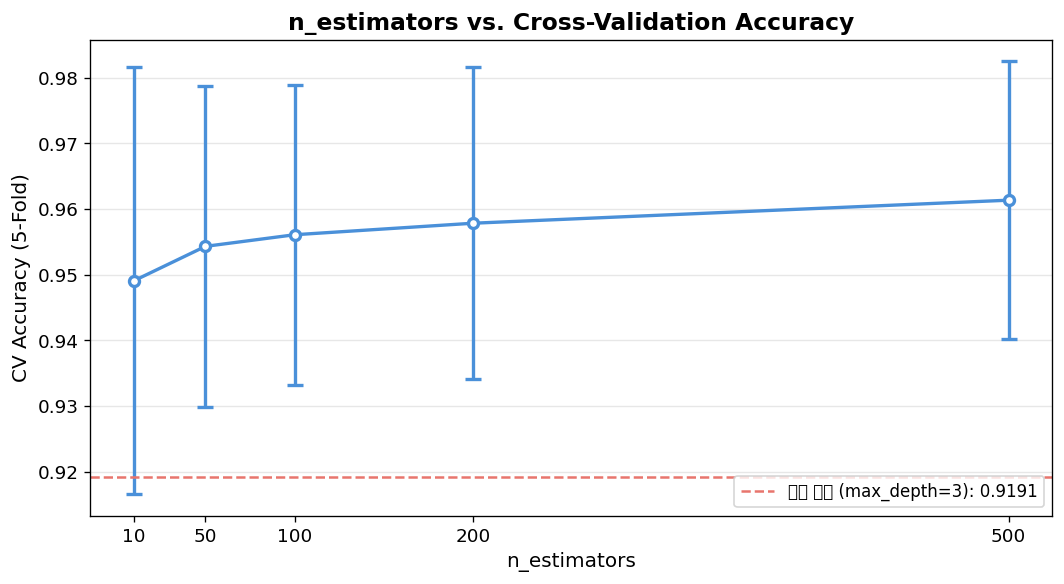

→ n_estimators를 키워도 정확도가 떨어지지 않는다 (과적합 X)
→ 100 이후로는 성능이 포화되며, 계산 시간만 증가한다


In [10]:
"""n_estimators에 따른 교차검증 정확도를 시각화한다."""

fig, ax = plt.subplots(figsize=(9, 5))

ax.errorbar(
    N_ESTIMATOR_VALUES, means, yerr=stds,
    marker="o", linewidth=2, capsize=5,
    color="#4A90D9", markerfacecolor="white", markeredgewidth=2,
)

# 단일 트리 기준선
tree_mean = scores_tree.mean()
ax.axhline(
    tree_mean, color="#E8756D", linestyle="--", linewidth=1.5,
    label=f"단일 트리 (max_depth=3): {tree_mean:.4f}",
)

ax.set_xlabel("n_estimators", fontsize=12)
ax.set_ylabel("CV Accuracy (5-Fold)", fontsize=12)
ax.set_title("n_estimators vs. Cross-Validation Accuracy",
             fontsize=14, fontweight="bold")
ax.set_xticks(N_ESTIMATOR_VALUES)
ax.legend(fontsize=10, loc="lower right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("→ n_estimators를 키워도 정확도가 떨어지지 않는다 (과적합 X)")
print("→ 100 이후로는 성능이 포화되며, 계산 시간만 증가한다")

## 📝 과제 2 (선택): 랜덤포레스트를 회귀에도 적용하기

> `RandomForestRegressor` + `load_diabetes()` 데이터로 실험하세요.
> 3주차 선형 회귀와 R² 점수를 비교해 보세요.

In [11]:
"""[선택 과제] RandomForestRegressor로 당뇨병 데이터를 회귀 분석한다."""

from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

diabetes = load_diabetes()
X_reg, y_reg = diabetes.data, diabetes.target

# 선형 회귀
lr = LinearRegression()
scores_lr = cross_val_score(lr, X_reg, y_reg, cv=CV_FOLDS, scoring="r2")

# 랜덤포레스트 회귀
rfr = RandomForestRegressor(
    n_estimators=100,
    random_state=RANDOM_STATE,
)
scores_rfr = cross_val_score(rfr, X_reg, y_reg, cv=CV_FOLDS, scoring="r2")

print(f"선형 회귀           R² = {scores_lr.mean():.4f}  (±{scores_lr.std():.4f})")
print(f"랜덤포레스트 회귀   R² = {scores_rfr.mean():.4f}  (±{scores_rfr.std():.4f})")

선형 회귀           R² = 0.4823  (±0.0493)
랜덤포레스트 회귀   R² = 0.4184  (±0.0559)


## 📝 과제 3 (선택): 주차 종합 비교

> 7주차 단일 트리 + 9주차 랜덤포레스트를 동일 데이터에서 비교:
> 1. 교차검증 성능 (5-fold, 정확도)
> 2. 피처 중요도 상위 3개가 동일한지?
> 3. 차이가 있다면 원인 추론 (피처 랜덤 선택 효과와 연결)

In [12]:
"""[선택 과제] 단일 트리 vs. 랜덤포레스트 종합 비교 리포트를 생성한다."""

# (1) 교차검증 성능
print("─" * 50)
print("[1] 교차검증 성능 비교")
print("─" * 50)
print(f"  단일 트리      : {scores_tree.mean():.4f}  (±{scores_tree.std():.4f})")
print(f"  랜덤포레스트   : {scores_rf.mean():.4f}  (±{scores_rf.std():.4f})")

# (2) 피처 중요도 상위 3개 비교
top3_tree = np.argsort(imp_tree)[::-1][:3]
top3_rf = np.argsort(imp_rf)[::-1][:3]

print()
print("─" * 50)
print("[2] 피처 중요도 상위 3개 비교")
print("─" * 50)
print("  단일 트리      :", [feature_names[i] for i in top3_tree])
print("  랜덤포레스트   :", [feature_names[i] for i in top3_rf])
print(f"  일치 여부      : {set(top3_tree) == set(top3_rf)}")

# (3) 원인 추론
print()
print("─" * 50)
print("[3] 차이 원인 추론")
print("─" * 50)
print("  → 랜덤포레스트는 각 분할에서 피처를 랜덤으로 일부만 고려한다.")
print("  → 강한 피처(worst radius)가 후보에서 빠지는 트리가 존재한다.")
print("  → 따라서 다른 피처들도 루트 분할에 사용될 기회를 얻고,")
print("    결과적으로 중요도 상위 피처의 구성이 달라질 수 있다.")

──────────────────────────────────────────────────
[1] 교차검증 성능 비교
──────────────────────────────────────────────────
  단일 트리      : 0.9191  (±0.0246)
  랜덤포레스트   : 0.9561  (±0.0228)

──────────────────────────────────────────────────
[2] 피처 중요도 상위 3개 비교
──────────────────────────────────────────────────
  단일 트리      : [np.str_('worst radius'), np.str_('worst concave points'), np.str_('worst texture')]
  랜덤포레스트   : [np.str_('worst area'), np.str_('worst concave points'), np.str_('mean concave points')]
  일치 여부      : False

──────────────────────────────────────────────────
[3] 차이 원인 추론
──────────────────────────────────────────────────
  → 랜덤포레스트는 각 분할에서 피처를 랜덤으로 일부만 고려한다.
  → 강한 피처(worst radius)가 후보에서 빠지는 트리가 존재한다.
  → 따라서 다른 피처들도 루트 분할에 사용될 기회를 얻고,
    결과적으로 중요도 상위 피처의 구성이 달라질 수 있다.


---

## 🔑 한 문장

> **"약한 트리 100개를 합치면, 하나의 강한 트리보다 성능이 높고 안정적이며,
> 피처 중요도도 더 신뢰할 수 있다. 대신 해석 가능성은 내려간다.
> 모델 선택은 상황에 따른 판단이다."**